Continuar a partir de 7:40 (aula 10)

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.ar_model import AutoReg as AR

In [50]:
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

### Exercício 

A sua missão é prever 3 meses de uma série temporal de 2 anos, com início no dia 2020-01-01 e término no dia 2021-12-30, usando os mesmos parâmetros de quebra de premissas apresentadas nas aulas anteriores

### Entregáveis:

In [51]:
# === 1. CRIAÇÃO DA SÉRIE COM QUEBRAS DE PREMISSAS ===
np.random.seed(42)
n = 500
trend = np.linspace(0, 0, n)
noise = np.random.normal(0, 1, n)
serie_perfeita = trend + noise
dates = pd.date_range(start='2020-01-01', end='2021-12-30', periods=n)
serie_perfeita = pd.Series(serie_perfeita, index=dates, name='serie_perfeita')

trend_break = np.linspace(0, 10, n)
seasonality = 3 * np.sin(2 * np.pi * np.arange(n) / 50)
autoregressive = np.zeros(n)
autoregressive[0] = noise[0]
for t in range(1, n):
    autoregressive[t] = 0.8 * autoregressive[t - 1] + np.random.normal(0, 0.5)
non_normal = noise * np.linspace(1, 3, n)
non_normal_noise = np.random.exponential(scale=1, size=n)
serie_final = (serie_perfeita + trend_break + seasonality + autoregressive + non_normal + non_normal_noise)
serie_final = pd.Series(serie_final, index=dates, name='serie_final')
serie_final = serie_final - serie_final.min() + 1

<Axes: ylabel='serie_final'>

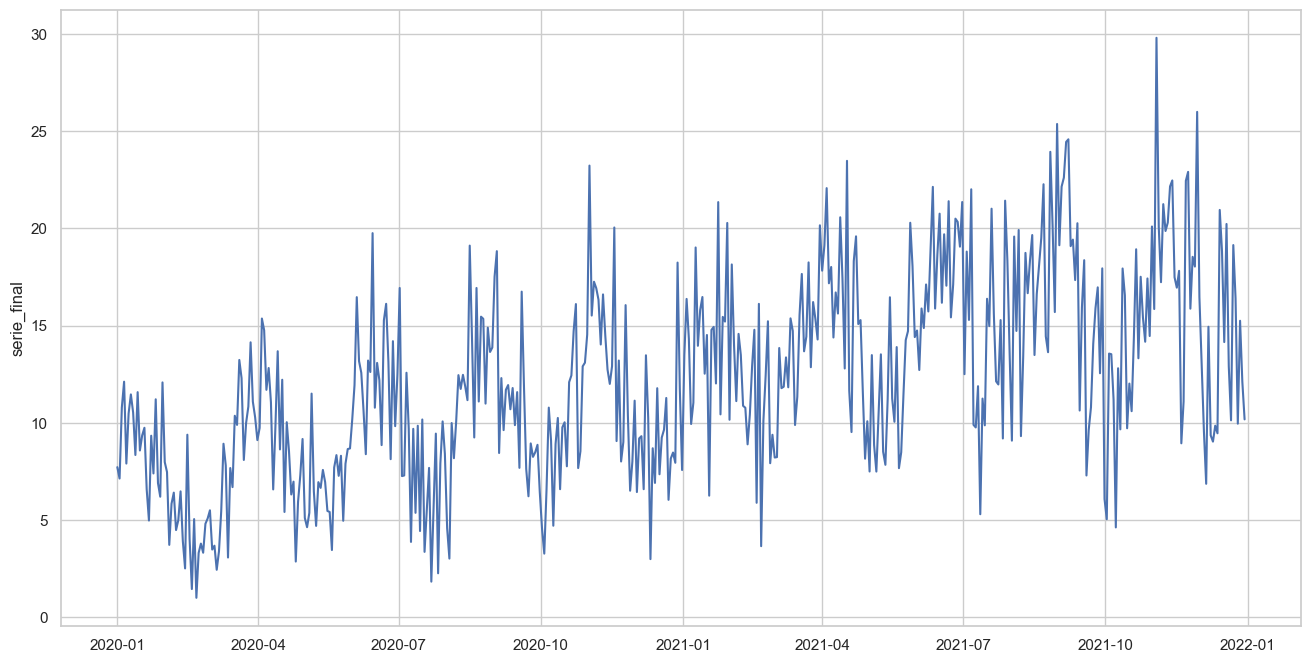

In [52]:
# Visualizacao das series
plt.figure( figsize=( 16, 8 ) )
sns.lineplot( serie_final )

In [53]:
# === 2. DIVISÃO TREINO / VALIDAÇÃO / TESTE ===
train_size = int(0.8 * len(serie_final))
validation_size = int(0.1 * len(serie_final))

train = serie_final[:train_size]
validation = serie_final[train_size:train_size + validation_size]
test = serie_final[train_size + validation_size:]

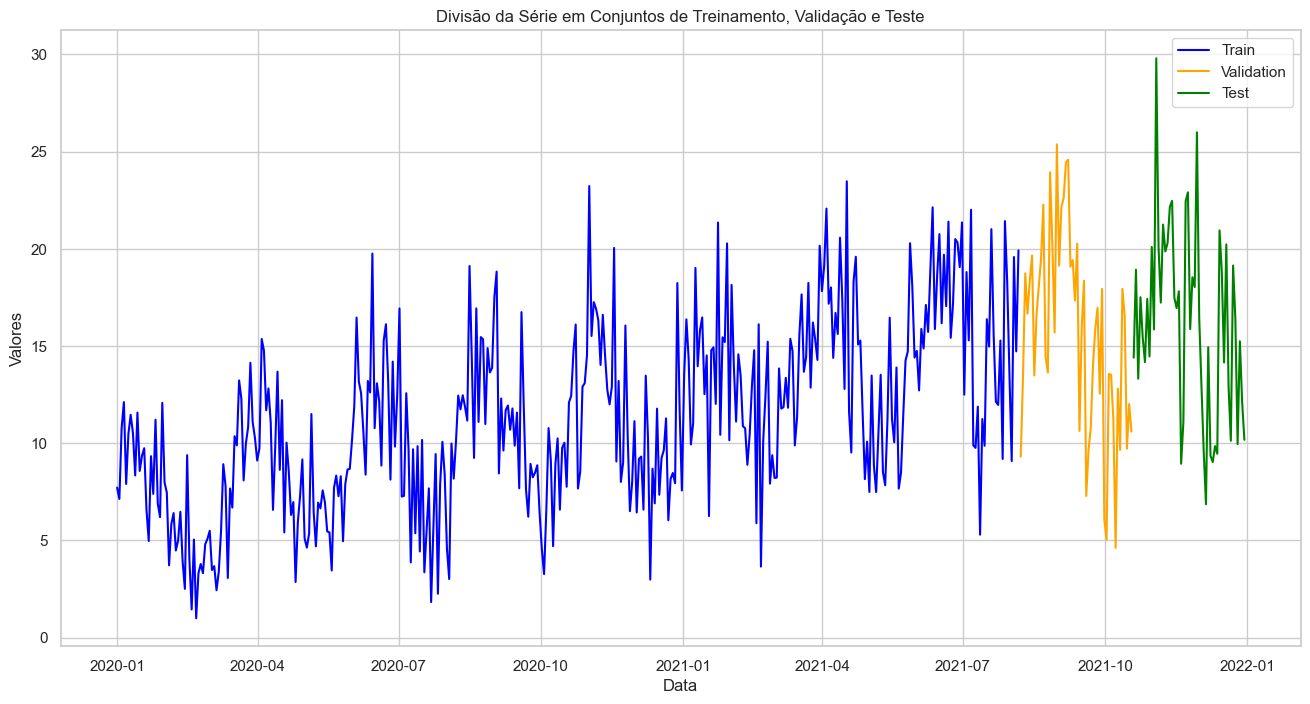

In [54]:
plt.figure( figsize=( 16, 8 ) )
sns.lineplot( train, label='Train', color='blue' )
sns.lineplot( validation, label='Validation', color='orange' )
sns.lineplot( test, label='Test', color='green' )
plt.title( 'Divisão da Série em Conjuntos de Treinamento, Validação e Teste' )
plt.xlabel( 'Data' )
plt.ylabel( 'Valores' )
plt.legend()

In [55]:
# === 3. FINE-TUNING PARA ESCOLHER O MELHOR LAG ===
lags_values = [1, 2, 3, 4, 5]
num_iterations = 3
results_val = pd.DataFrame()

for _ in range(num_iterations):
    lag = np.random.choice(lags_values)
    predictions, actuals = [], []
    train_series = train.copy()
    
    for t in range(len(validation)):
        model = AR(train_series, lags=lag)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        predictions.append(forecast)
        actuals.append(validation.iloc[t])
        train_series = pd.concat([train_series, pd.Series([validation.iloc[t]], index=[validation.index[t]])])
    
    df_val = pd.DataFrame({'Previsão': predictions, 'Real': actuals}, index=validation.index)
    errors = df_val['Real'] - df_val['Previsão']
    
    rmse = np.sqrt((errors ** 2).mean())
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / df_val['Real']))
    
    log_likelihood = model_fit.llf
    num_params = model_fit.params.shape[0]
    num_obs = len(train_series)
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(num_obs)

    performance = pd.DataFrame({
        'Lag': [lag],
        'RMSE_VAL': [rmse],
        'MAE_VAL': [mae],
        'MAPE_VAL': [mape],
        'AIC_VAL': [aic],
        'BIC_VAL': [bic]
    })
    results_val = pd.concat([results_val, performance], ignore_index=True)

In [57]:
results_val

,Lag,RMSE_VAL,MAE_VAL,MAPE_VAL,AIC_VAL,BIC_VAL
0,3,4.395035,3.768235,0.313443,2389.491687,2405.928678
1,1,4.847001,4.013134,0.309080,2488.704187,2496.922683
2,5,4.266532,3.566331,0.299512,2366.905568,2391.561053


In [59]:
# === 4. ESCOLHENDO O MELHOR LAG ===
melhor_lag = int(results_val.sort_values(by='RMSE_VAL').iloc[0]['Lag'])
print(f"Melhor lag selecionado: {melhor_lag}")

Melhor lag selecionado: 5


In [60]:
# === 5. PREVISÃO NO CONJUNTO DE TESTE ===
predictions, actuals = [], []
train_series = pd.concat([train, validation])

for t in range(len(test)):
    model = AR(train_series, lags=melhor_lag)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).iloc[0]
    predictions.append(forecast)
    actuals.append(test.iloc[t])
    train_series = pd.concat([train_series, pd.Series([test.iloc[t]], index=[test.index[t]])])

df_test = pd.DataFrame({'Previsão': predictions, 'Real': actuals}, index=test.index)
errors = df_test['Real'] - df_test['Previsão']

rmse_test = np.sqrt((errors ** 2).mean())
mae_test = np.abs(errors).mean()
mape_test = np.mean(np.abs(errors / df_test['Real']))

log_likelihood = model_fit.llf
num_params = model_fit.params.shape[0]
num_obs = len(train_series)
aic_test = -2 * log_likelihood + 2 * num_params
bic_test = -2 * log_likelihood + num_params * np.log(num_obs)

print("\nDesempenho no Conjunto de Teste:")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE:  {mae_test:.4f}")
print(f"MAPE: {mape_test:.4f}")
print(f"AIC:  {aic_test:.2f}")
print(f"BIC:  {bic_test:.2f}")


Desempenho no Conjunto de Teste:
RMSE: 4.6913
MAE:  3.5123
MAPE: 0.2387
AIC:  2671.78
BIC:  2697.07


In [61]:
# === 6. PREVISÃO DOS PRÓXIMOS 90 DIAS ===
forecast_series = pd.concat([train, validation, test])
future_predictions = []

for _ in range(90):
    model = AR(forecast_series, lags=melhor_lag)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1).iloc[0]
    future_predictions.append(forecast)
    next_index = forecast_series.index[-1] + pd.Timedelta(days=1)
    forecast_series = pd.concat([forecast_series, pd.Series([forecast], index=[next_index])])

future_dates = pd.date_range(start=forecast_series.index[-90], periods=90, freq='D')
future_series = pd.Series(future_predictions, index=future_dates)

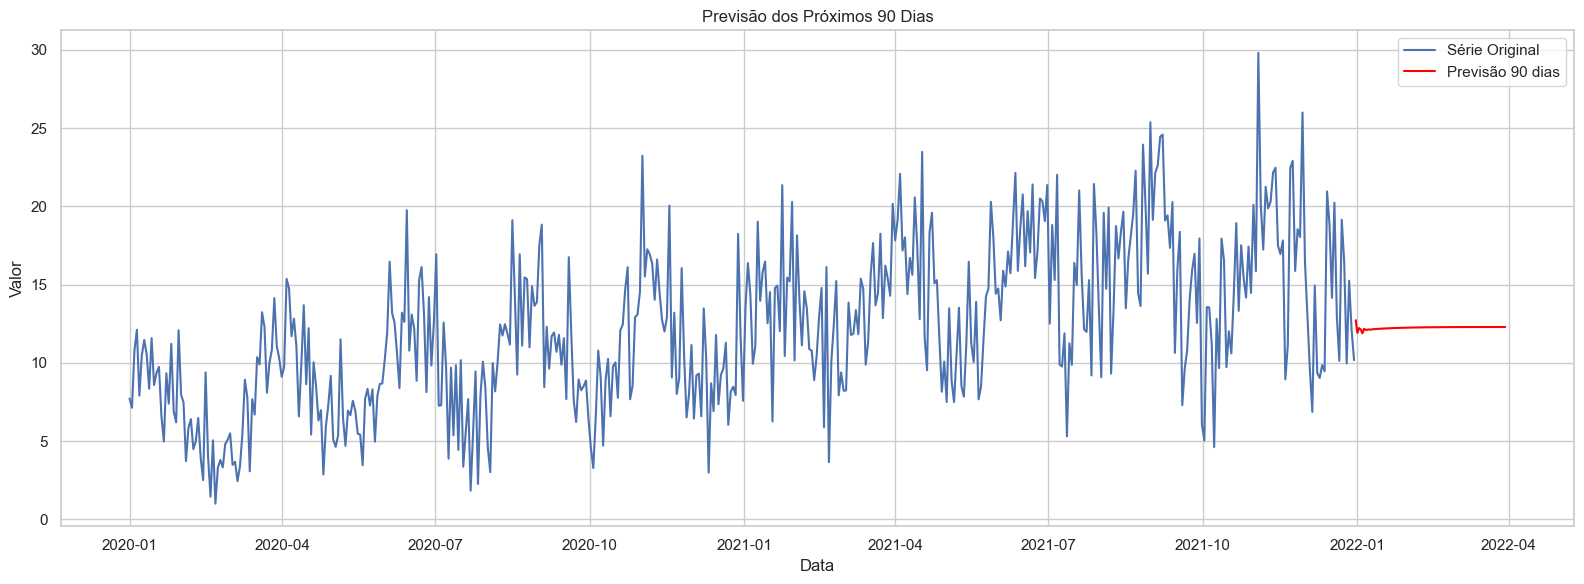

In [63]:
# === 7. PLOT FINAL ===
plt.figure(figsize=(16, 6))
sns.lineplot(data=serie_final, label='Série Original')
sns.lineplot(data=future_series, label='Previsão 90 dias', color='red')
plt.title('Previsão dos Próximos 90 Dias')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()

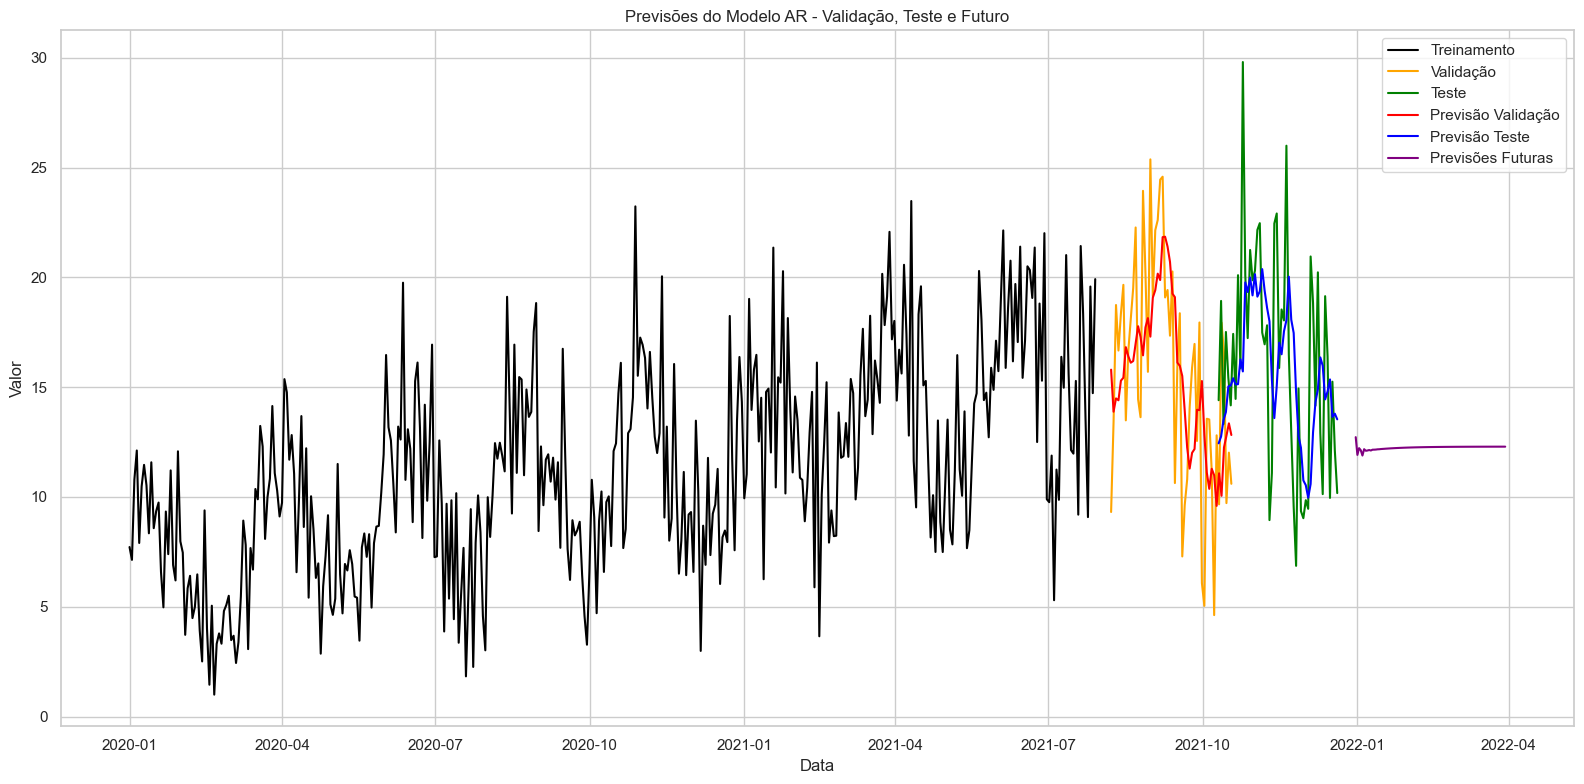

In [65]:
plt.figure(figsize=(16, 8))

# Plots principais
sns.lineplot(data=train, label='Treinamento', color='black')
sns.lineplot(data=validation, label='Validação', color='orange')
sns.lineplot(data=test, label='Teste', color='green')

# Previsões
sns.lineplot(data=df_val['Previsão'], label='Previsão Validação', color='red')
sns.lineplot(data=df_test['Previsão'], label='Previsão Teste', color='blue')

# Previsões Futuras
if 'future_series' in locals():
    sns.lineplot(data=future_series, label='Previsões Futuras', color='purple')

# Detalhes do gráfico
plt.title('Previsões do Modelo AR - Validação, Teste e Futuro')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.legend()
plt.tight_layout()
plt.show()


### Teste modularizado

Melhor lag encontrado: 5

Métricas no conjunto de teste:
{'RMSE': np.float64(4.691250583539601), 'MAE': np.float64(3.5122919980679175), 'MAPE': np.float64(0.238673438110956), 'AIC': np.float64(2671.780423105161), 'BIC': np.float64(2697.068071695694)}


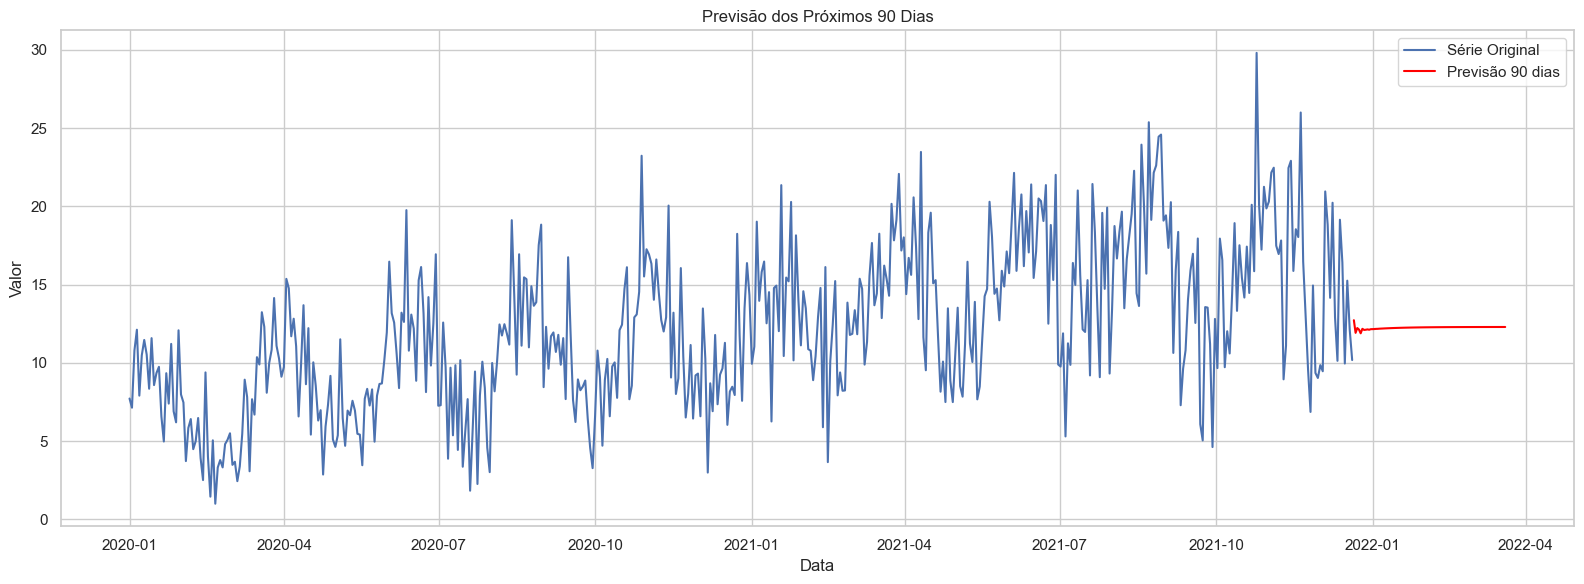

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.ar_model import AutoReg as AR

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ==== FUNÇÃO 1: GERAR SÉRIE TEMPORAL COM QUEBRAS ====
def gerar_serie_quebrada(n=500):
    np.random.seed(42)
    trend = np.linspace(0, 0, n)
    noise = np.random.normal(0, 1, n)
    dates = pd.date_range(start='2020-01-01', end='2021-12-20', periods=n)
    serie_perfeita = pd.Series(trend + noise, index=dates)

    trend_break = np.linspace(0, 10, n)
    seasonality = 3 * np.sin(2 * np.pi * np.arange(n) / 50)

    autoregressive = np.zeros(n)
    autoregressive[0] = noise[0]
    for t in range(1, n):
        autoregressive[t] = 0.8 * autoregressive[t-1] + np.random.normal(0, 0.5)

    non_normal = noise * np.linspace(1, 3, n)
    non_normal_noise = np.random.exponential(scale=1, size=n)

    serie_final = serie_perfeita + trend_break + seasonality + autoregressive + non_normal + non_normal_noise
    serie_final = pd.Series(serie_final - serie_final.min() + 1, index=dates, name="serie_final")

    return serie_final

# ==== FUNÇÃO 2: SPLIT TRAIN / VALID / TEST ====
def dividir_dados(serie, train_ratio=0.8, val_ratio=0.1):
    n = len(serie)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    return serie[:train_end], serie[train_end:val_end], serie[val_end:]

# ==== FUNÇÃO 3: ROLLING FORECAST + AVALIAÇÃO ====
def rolling_forecast(train, val, lag):
    predictions, actuals = [], []
    train_series = train.copy()

    for t in range(len(val)):
        model = AR(train_series, lags=lag)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        predictions.append(forecast)
        actuals.append(val.iloc[t])
        train_series = pd.concat([train_series, pd.Series([val.iloc[t]], index=[val.index[t]])])

    df_val = pd.DataFrame({'Previsão': predictions, 'Real': actuals}, index=val.index)
    errors = df_val['Real'] - df_val['Previsão']

    rmse = np.sqrt((errors ** 2).mean())
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / df_val['Real']))

    log_likelihood = model_fit.llf
    num_params = model_fit.params.shape[0]
    num_obs = len(train_series)
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(num_obs)

    return df_val, {'lag': lag, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'AIC': aic, 'BIC': bic}

# ==== FUNÇÃO 4: FINE-TUNING ====
def fine_tuning(train, val, lags_list, iterations=3):
    results = []
    for _ in range(iterations):
        lag = np.random.choice(lags_list)
        _, metrics = rolling_forecast(train, val, lag)
        results.append(metrics)
    return pd.DataFrame(results).sort_values(by='RMSE')

# ==== FUNÇÃO 5: PREVISÃO SOBRE CONJUNTO DE TESTE ====
def avaliar_no_teste(train, val, test, lag):
    train_series = pd.concat([train, val])
    predictions, actuals = [], []

    for t in range(len(test)):
        model = AR(train_series, lags=lag)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        predictions.append(forecast)
        actuals.append(test.iloc[t])
        train_series = pd.concat([train_series, pd.Series([test.iloc[t]], index=[test.index[t]])])

    df_test = pd.DataFrame({'Previsão': predictions, 'Real': actuals}, index=test.index)
    errors = df_test['Real'] - df_test['Previsão']

    rmse = np.sqrt((errors ** 2).mean())
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / df_test['Real']))

    log_likelihood = model_fit.llf
    num_params = model_fit.params.shape[0]
    num_obs = len(train_series)
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(num_obs)

    return df_test, {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'AIC': aic, 'BIC': bic}

# ==== FUNÇÃO 6: PREVISÃO FUTURA ====
def prever_futuro(serie, lag, dias=90):
    future_series = serie.copy()
    previsoes = []

    for _ in range(dias):
        model = AR(future_series, lags=lag)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        previsoes.append(forecast)
        proxima_data = future_series.index[-1] + pd.Timedelta(days=1)
        future_series = pd.concat([future_series, pd.Series([forecast], index=[proxima_data])])

    datas_futuras = pd.date_range(start=future_series.index[-dias], periods=dias, freq='D')
    return pd.Series(previsoes, index=datas_futuras)

# ==== FUNÇÃO 7: VISUALIZAÇÃO ====
def plotar_previsao(original, futuro):
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=original, label='Série Original')
    sns.lineplot(data=futuro, label='Previsão 90 dias', color='red')
    plt.title('Previsão dos Próximos 90 Dias')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ==== EXECUÇÃO ====
if __name__ == "__main__":
    serie = gerar_serie_quebrada()
    train, val, test = dividir_dados(serie)

    resultados = fine_tuning(train, val, lags_list=[1, 2, 3, 4, 5])
    melhor_lag = int(resultados.iloc[0]['lag'])
    print(f"Melhor lag encontrado: {melhor_lag}")

    df_test, metricas_teste = avaliar_no_teste(train, val, test, melhor_lag)
    print("\nMétricas no conjunto de teste:")
    print(metricas_teste)

    previsao_futura = prever_futuro(pd.concat([train, val, test]), melhor_lag, dias=90)
    plotar_previsao(serie, previsao_futura)
